# Correlation analysis

This notebook creates the correlation matrix using SPELL processed data.

The decision to process the data using SPELL as opposed to applying the correlation directly to the counts matrix can be found in [spell_vs_counts_experiment](spell_vs_counts_experiment/1a_compare_SPELL_vs_counts_correlation.ipynb)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os
import pandas as pd
import plotnine as pn
import seaborn as sns
from sklearn import preprocessing
import matplotlib.pyplot as plt
import umap
import random
import numpy as np
import scipy
from scipy.spatial.distance import pdist, squareform
from sklearn.decomposition import PCA
from scripts import paths, utils

/home/alexandra/anaconda3/envs/core_acc/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))


## Set user parameters

Here we set the number of PCs or singular vectors to use. We are starting with 300 since this is what [eADAGE](https://pubmed.ncbi.nlm.nih.gov/28711280/) used.

In [2]:
# Params

# Which subset of genes to consider: core, acc, all
subset_genes = "acc"

if subset_genes == "acc":
    num_SVs = 50
else:
    num_SVs = 100

In [3]:
# Load expression data
pao1_compendium_filename = paths.PAO1_COMPENDIUM
pa14_compendium_filename = paths.PA14_COMPENDIUM

In [4]:
pao1_compendium = pd.read_csv(pao1_compendium_filename, sep="\t", header=0, index_col=0)
pa14_compendium = pd.read_csv(pa14_compendium_filename, sep="\t", header=0, index_col=0)

In [5]:
print(pao1_compendium.shape)
pao1_compendium.head()

(890, 5563)


,PA0001,PA0002,PA0003,PA0004,PA0005,PA0006,PA0007,PA0008,PA0009,PA0010,...,PA1905,PA0195,PA4812,PA0195.1,PA0457.1,PA1552.1,PA1555.1,PA3701,PA4724.1,PA5471.1
ERX541571,5621.037929,902.172829,1380.825635,1811.863764,140.337996,508.725234,483.664878,666.605479,681.641693,77.687105,...,0.0,97.735390,471.134699,12.530178,87.711247,75.181069,77.687105,2288.010535,250.603564,0.000000
ERX541572,6323.898054,835.453446,1754.599065,1814.798699,190.876886,418.460865,321.554138,493.343336,666.600816,45.516796,...,0.0,80.755606,487.470201,10.277986,70.477619,46.985080,60.199633,2218.576726,199.686588,0.000000
ERX541573,4954.119979,893.818410,1984.802645,1752.146970,350.955170,362.785119,373.300630,465.311348,616.471815,42.062043,...,0.0,114.356179,782.091108,19.716583,153.789344,43.376482,106.469546,1474.800376,101.211790,0.000000
ERX541574,4603.356163,773.573295,2227.891090,1911.321096,311.809544,323.710671,435.581271,435.581271,506.988037,78.547442,...,0.0,152.334434,561.733224,21.422030,85.688119,38.083608,64.266089,2116.020491,78.547442,2.380226
ERX541575,4260.451254,875.408119,2140.106080,1788.361959,320.126671,288.509222,276.652679,577.018444,739.057871,57.306626,...,0.0,136.350249,677.799063,15.808725,195.632966,21.736996,118.565434,1650.035620,61.258807,0.000000


In [6]:
print(pa14_compendium.shape)
pa14_compendium.head()

(505, 5891)


,PA14_55610,PA14_55600,PA14_55590,PA14_55580,PA14_55570,PA14_55560,PA14_55550,PA14_55540,PA14_55530,PA14_55520,...,PA14_19205,PA14_17675,PA14_67975,PA14_36345,PA14_43405,PA14_38825,PA14_24245,PA14_28895,PA14_55117,PA14_59845
ERX1477379,248.707957,13.753435,2.292239,264.753632,68.767177,22.922392,19.484033,55.013742,24.068512,2.292239,...,33.237469,174.210182,1118.612747,264.753632,2.292239,11.461196,449.278890,293.406622,171.917943,181.086900
ERX2174773,56.232678,27.502445,8.594514,7.612284,22.836852,12.032320,5.402266,10.558975,56.723793,6.875611,...,84.226239,46.655934,1115.076822,529.913187,0.000000,43.463686,135.056651,560.853438,73.421707,139.476687
ERX2174774,67.495419,21.860864,9.017607,6.284999,19.401517,12.023475,3.279130,16.395648,60.390638,4.372173,...,89.356283,35.250644,1028.553671,532.038788,0.000000,49.733467,142.915401,738.897218,69.954766,160.404093
ERX2174775,58.088081,24.116927,7.001688,3.889827,18.411847,9.335584,3.889827,16.596595,46.159279,2.852540,...,87.650765,54.716898,1157.612474,485.450392,0.518644,35.267764,168.040520,817.382285,56.532150,67.164344
ERX2174776,50.207404,23.036339,9.746143,4.430065,21.264312,10.632156,4.134727,12.994858,54.342132,2.362701,...,90.964003,49.321391,1087.433313,650.924232,0.295338,50.798080,132.015940,611.348984,64.678950,124.041823


## Get core/accessory genes

We will subset the correlation matrix to only consider core genes.

_Rationale:_ Previously we used all genes (both core and accessory) to create a co-expression network, but due to the large imbalance in the number of core genes compared to accessory genes, no module was found to be "mostly core." Instead we will perform separate analyses of core and accessory genes to examine co-expression patterns.

In [7]:
# Read in expression data
pao1_expression_filename = paths.PAO1_COMPENDIUM
pa14_expression_filename = paths.PA14_COMPENDIUM

pao1_expression = pd.read_csv(pao1_expression_filename, sep="\t", index_col=0, header=0)
pa14_expression = pd.read_csv(pa14_expression_filename, sep="\t", index_col=0, header=0)

In [8]:
pao1_annot_filename = paths.GENE_PAO1_ANNOT
pa14_annot_filename = paths.GENE_PA14_ANNOT

core_acc_dict = utils.get_my_core_acc_genes(
    pao1_annot_filename, pa14_annot_filename, pao1_expression, pa14_expression
)

Number of PAO1 core genes: 5366
Number of PA14 core genes: 5363
Number of PAO1 core genes in my dataset: 5361
Number of PA14 core genes in my dataset: 5361
Number of PAO1-specific genes: 202
Number of PA14-specific genes: 530


In [9]:
pao1_core = core_acc_dict["core_pao1"]
pa14_core = core_acc_dict["core_pa14"]
pao1_acc = core_acc_dict["acc_pao1"]
pa14_acc = core_acc_dict["acc_pa14"]

## Select subset of genes

In [10]:
# Select subset of genes
if subset_genes == "core":
    pao1_compendium = pao1_compendium[pao1_core]
    pa14_compendium = pa14_compendium[pa14_core]
elif subset_genes == "acc":
    pao1_compendium = pao1_compendium[pao1_acc]
    pa14_compendium = pa14_compendium[pa14_acc]

In [11]:
print(pao1_compendium.shape)
print(pa14_compendium.shape)

(890, 202)
(505, 530)


## Log transform + SPELL Correlation

_Review of SVD_

Singular Value Decomposition is a way to factorize your matrix, $X^{mxn}$ into singular vectors and singular values: $X = U \Sigma V^*$

In our case $X$ is **gene x sample** and then the columns of $U$ (gene x eigensample) are the left singular vectors (gene coefficient vectors); $\Sigma$ (eigengene x eigensample) has singular values and is diagonal (mode amplitudes); and $V^T$ (eigengene x sample) has rows that are the right singular vectors (expression level vectors).

Here we are using SVD to reduce the noise in our original data by performing dimensionality reduction. This dimensionality is done by neglecting the small singular values in the diagonal matrix $\Sigma$. Normally people would get the projection of the original data onto the singular vectors by $U \Sigma$ and apply the correlation on the projected data. Here, we're following the description in [Hibbs et. al.](https://academic.oup.com/bioinformatics/article/23/20/2692/229926) where they performed correlation on $U$ only.

From [Hibbs et. al.](https://academic.oup.com/bioinformatics/article/23/20/2692/229926), we apply their "signal balancing technique that enhances biological information". This is the first part of their [SPELL](https://spell.yeastgenome.org/) algorithm that is described in section 2.3.1. SPELL calculates the correlation on the gene coefficient matrix, $U$ (i.e. how much genes contribute to a latent variable) that is generated after applying SVD. This matrix represents how genes contribute to independent latent variables that capture the signal in the data where the variance of the variables is 1. The idea is that correlations between gene contributions are more balanced so that less prominent patterns are amplified and more dominant patterns are dampended due to this compression. Figure 3 shows how well SPELL recapitulates biology (i.e. the relationship between genes within a GO term) compared to Pearson correlation.

In [12]:
# Transpose compendia to be gene x sample
# Here we're interested in how genes cluster
pao1_compendium_T = pao1_compendium.T
pa14_compendium_T = pa14_compendium.T

In [13]:
# log transform data
pao1_compendium_log10 = np.log10(1 + pao1_compendium_T)
pa14_compendium_log10 = np.log10(1 + pa14_compendium_T)

In [14]:
# Apply SVD
pao1_U, pao1_s, pao1_Vh = np.linalg.svd(pao1_compendium_log10, full_matrices=False)
pa14_U, pa14_s, pa14_Vh = np.linalg.svd(pa14_compendium_log10, full_matrices=False)

In [15]:
print(pao1_compendium_T.shape)
print(pao1_U.shape, pao1_s.shape, pao1_Vh.shape)

(202, 890)
(202, 202) (202,) (202, 890)


In [16]:
print(pa14_compendium_T.shape)
print(pa14_U.shape, pa14_s.shape, pa14_Vh.shape)

(530, 505)
(530, 505) (505,) (505, 505)


In [17]:
# Convert ndarray to df to use corr()
pao1_U_df = pd.DataFrame(data=pao1_U, index=pao1_compendium_T.index)
pa14_U_df = pd.DataFrame(data=pa14_U, index=pa14_compendium_T.index)

In [18]:
pao1_U_df.head()

,0,1,2,3,4,5,6,7,8,9,...,192,193,194,195,196,197,198,199,200,201
PA0643,-0.079473,-0.118674,0.031931,0.100809,0.015116,0.054831,0.049880,-0.005742,0.053820,-0.086161,...,-0.094153,-0.016264,-0.277173,0.024275,0.042854,0.000763,0.081061,-0.021107,0.017551,-0.043561
PA3143,-0.081380,-0.051656,-0.078715,-0.059311,-0.028995,0.007102,-0.025153,-0.010891,-0.005332,-0.065410,...,-0.005712,-0.088329,0.016382,0.090077,-0.029412,0.003349,0.019543,-0.092818,0.002142,-0.058183
PA2853,-0.146445,-0.007369,0.064948,-0.095235,-0.111367,0.239010,-0.029378,0.086807,0.063666,0.024882,...,0.028408,0.023948,0.018992,-0.043702,0.016515,-0.008290,0.027722,-0.041033,-0.007072,0.004122
PA1388,-0.058260,0.017089,-0.065619,0.061369,0.142790,0.050390,-0.107661,-0.098057,-0.016671,0.004112,...,0.084111,0.012910,-0.030751,0.100929,0.018362,-0.002203,0.007541,-0.008176,-0.002599,-0.018857
PA3843,-0.055601,0.068710,-0.009524,0.003173,0.001365,-0.012109,-0.028370,0.008233,0.031631,0.004099,...,-0.001354,0.005165,-0.034926,0.019568,0.022547,-0.000733,-0.000763,0.007935,0.009853,-0.013835


In [19]:
# Correlation of U
# Since `corr()` computes pairwise correlation of columns we need to invert U
pao1_corr_log_spell = pao1_U_df.iloc[:, :num_SVs].T.corr()
pa14_corr_log_spell = pa14_U_df.iloc[:, :num_SVs].T.corr()

In [20]:
print(pao1_U_df.iloc[:, :num_SVs].shape)

(202, 50)


In [21]:
# Check for duplicates indices
assert pao1_corr_log_spell.index.duplicated().sum() == 0
assert pa14_corr_log_spell.index.duplicated().sum() == 0

In [22]:
# Check for duplicate rows
assert pao1_corr_log_spell[pao1_corr_log_spell.duplicated(keep=False)].shape[0] == 0
assert pa14_corr_log_spell[pa14_corr_log_spell.duplicated(keep=False)].shape[0] == 0

In [23]:
# Plot distribution of scores
triu_pao1_corr_df = pao1_corr_log_spell.where(
    np.triu(np.ones(pao1_corr_log_spell.shape)).astype(np.bool)
)

flat_pao1_corr_df = triu_pao1_corr_df.stack().reset_index()
flat_pao1_corr_df.columns = ["gene_1", "gene_2", "corr_val"]

triu_pa14_corr_df = pa14_corr_log_spell.where(
    np.triu(np.ones(pa14_corr_log_spell.shape)).astype(np.bool)
)

flat_pa14_corr_df = triu_pa14_corr_df.stack().reset_index()
flat_pa14_corr_df.columns = ["gene_1", "gene_2", "corr_val"]

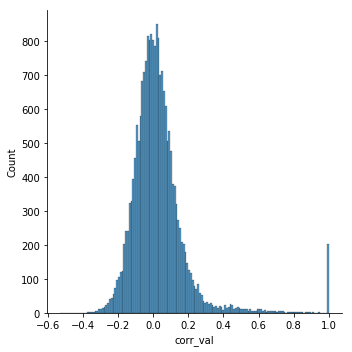

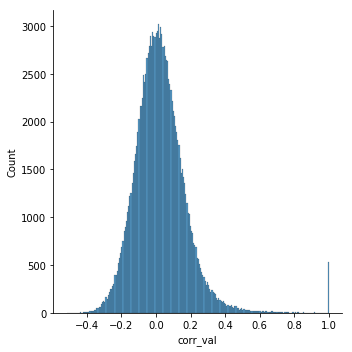

In [24]:
sns.displot(flat_pao1_corr_df["corr_val"])
sns.displot(flat_pa14_corr_df["corr_val"])

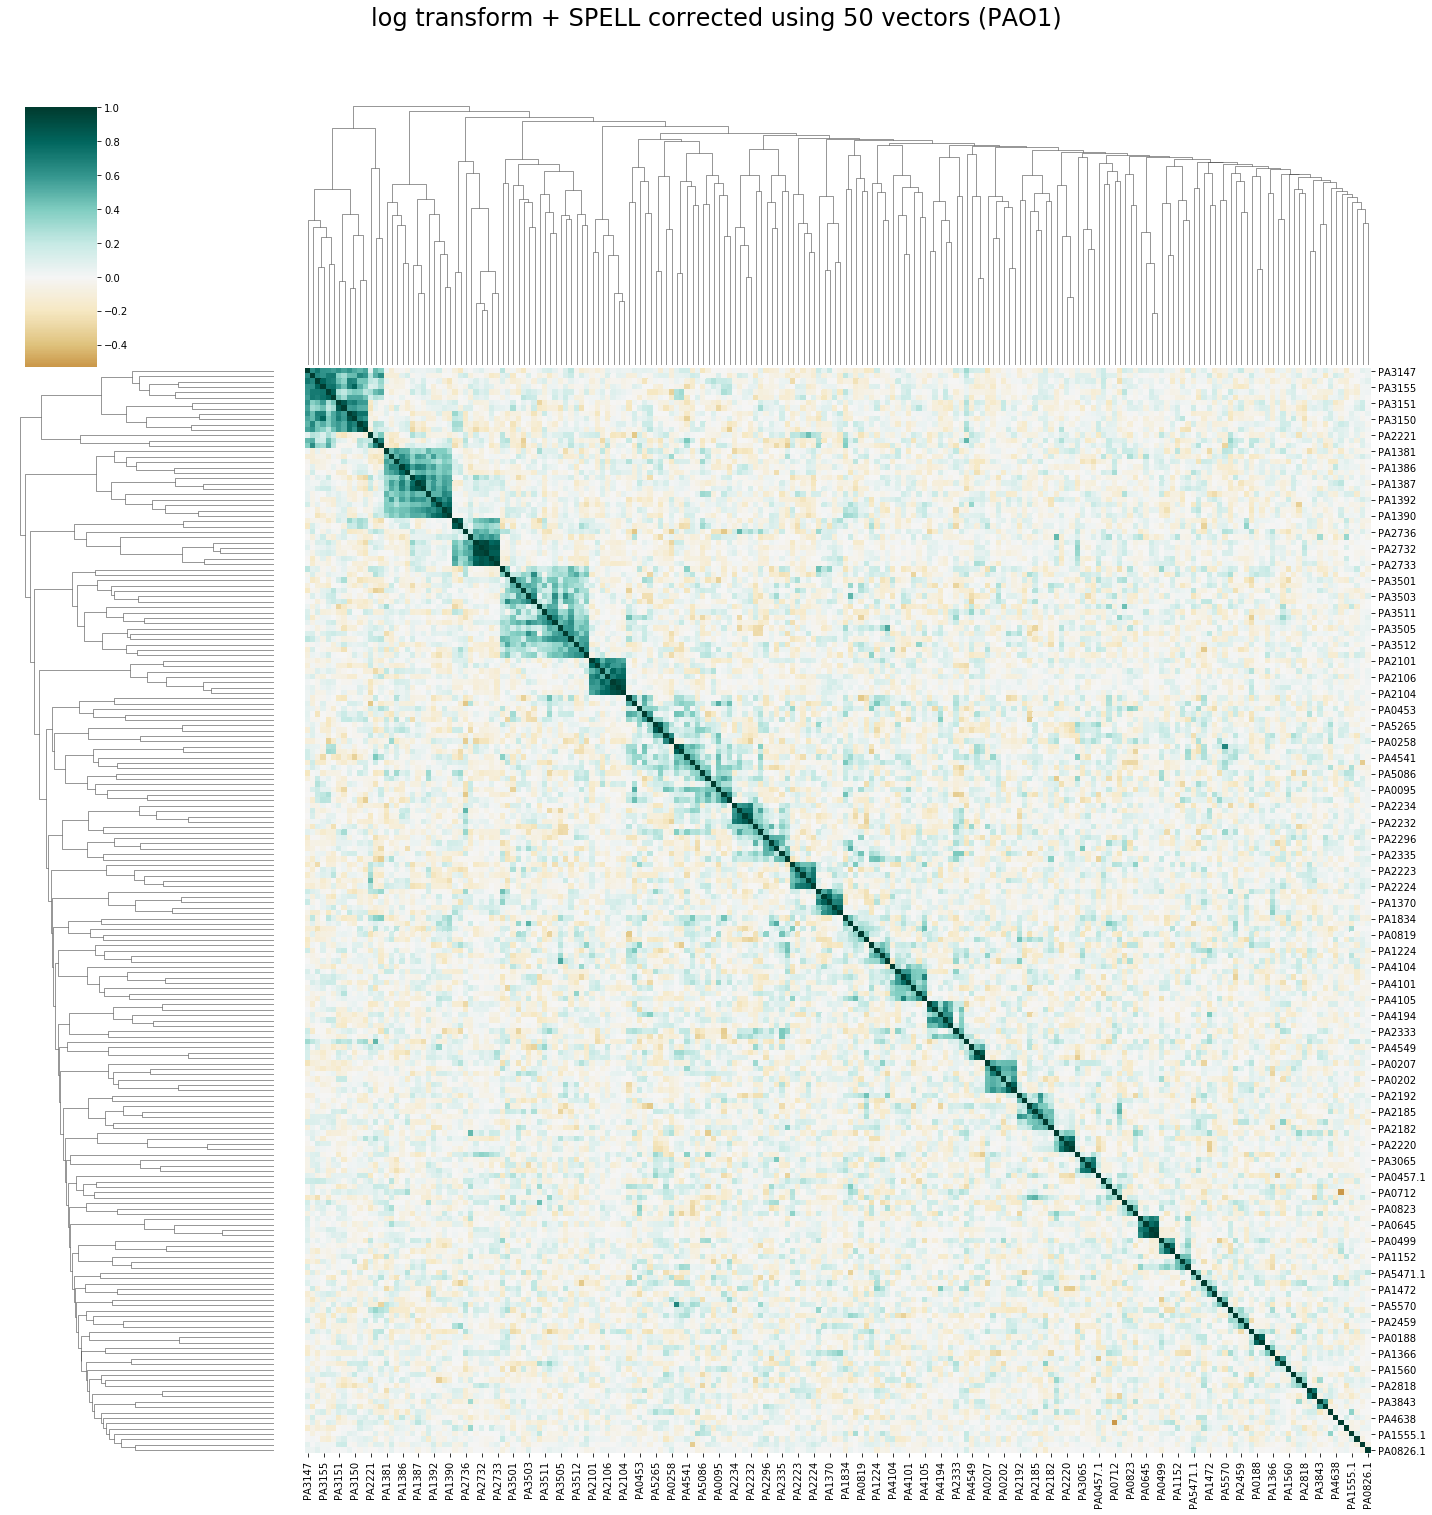

In [25]:
# Plot heatmap
h1a = sns.clustermap(pao1_corr_log_spell, cmap="BrBG", center=0, figsize=(20, 20))
h1a.fig.suptitle(
    f"log transform + SPELL corrected using {num_SVs} vectors (PAO1)",
    y=1.05,
    fontsize=24,
)

# Save
pao1_log_spell_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pao1_{subset_genes}_log_spell_clustermap.png"
)
h1a.savefig(pao1_log_spell_filename, dpi=300)

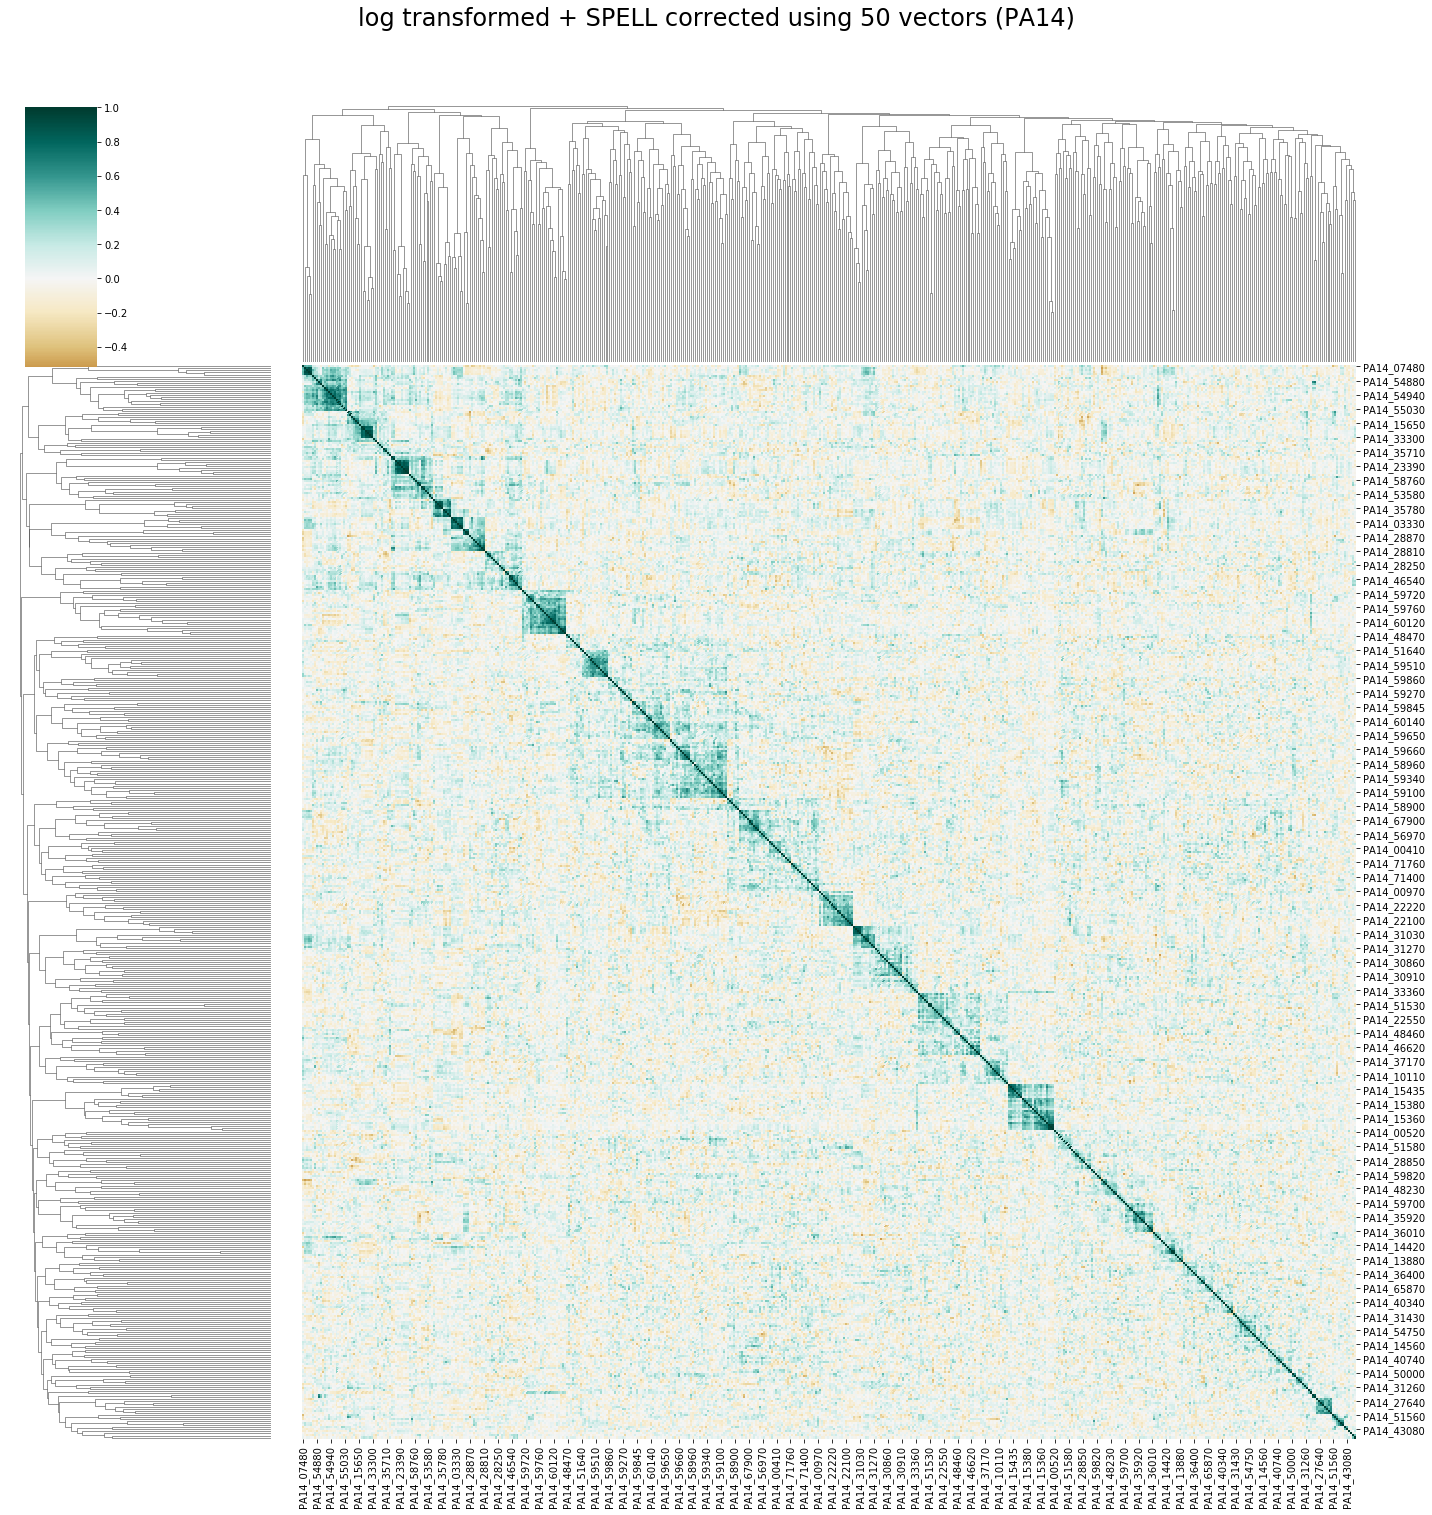

In [26]:
h2a = sns.clustermap(pa14_corr_log_spell, cmap="BrBG", center=0, figsize=(20, 20))
h2a.fig.suptitle(
    f"log transformed + SPELL corrected using {num_SVs} vectors (PA14)",
    y=1.05,
    fontsize=24,
)

# Save
pa14_log_spell_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pa14_{subset_genes}_log_spell_clustermap.png"
)
h2a.savefig(pa14_log_spell_filename, dpi=300)

## Plot distribution of pairwise distances

This will particularly help to inform the parameters we use for DBSCAN, which is density based. Here we looking at the distribution of both global distances and local distances. Global distances are defined using `pdist`, which takes the pairwise Euclidean distance of each of the correlation vectors (so the distance between gene `p` and gene `q` is based on the difference in correlation between `p` and all other genes, and `q` and all other genes). Whereas the local distance is defined as 1 - |correlation(`p`, `q`)|

Text(0.5, 1.0, 'Distribution of pairwise distances for PAO1 genes')

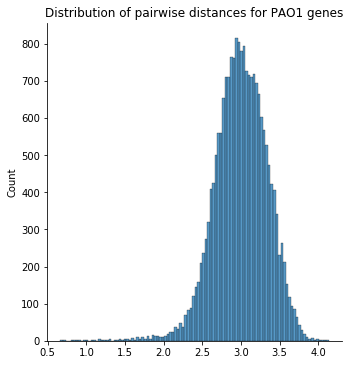

In [27]:
# Get distribution of pairwise distances to determine a cutoff defining what a dense region should be
f1 = sns.displot(pdist(pao1_corr_log_spell))
plt.title("Distribution of pairwise distances for PAO1 genes")

Text(0.5, 1.0, 'Distribution of pairwise distances for PA14 genes')

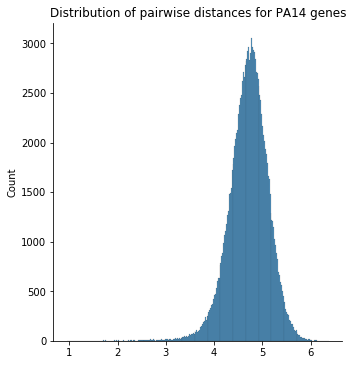

In [28]:
f2 = sns.displot(pdist(pa14_corr_log_spell))
plt.title("Distribution of pairwise distances for PA14 genes")

In [29]:
pao1_local_dist = 1 - pao1_corr_log_spell.abs()
pao1_local_dist = pao1_local_dist.where(
    np.triu(np.ones(pao1_local_dist.shape), k=1).astype(np.bool)
)
pao1_local_dist = pao1_local_dist.stack().reset_index()
pao1_local_dist.columns = ["Row", "Column", "Value"]

pao1_local_dist.head(10)

,Row,Column,Value
0,PA0643,PA3143,0.988125
1,PA0643,PA2853,0.923326
2,PA0643,PA1388,0.978617
3,PA0643,PA3843,0.895151
4,PA0643,PA3701,0.944556
5,PA0643,PA3514,0.997985
6,PA0643,PA2101,0.973730
7,PA0643,PA2185,0.922016
8,PA0643,PA2229,0.890276
9,PA0643,PA5265,0.924593


Text(0.5, 1.0, 'Distribution of pairwise distances for PAO1 genes')

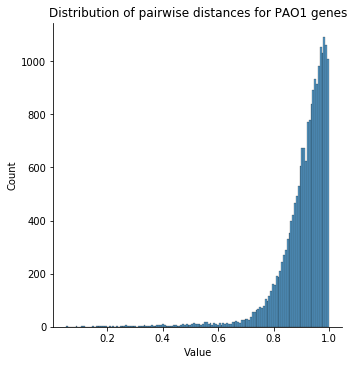

In [30]:
f3 = sns.displot(pao1_local_dist["Value"])
plt.title("Distribution of pairwise distances for PAO1 genes")

In [31]:
pa14_local_dist = 1 - pa14_corr_log_spell.abs()
pa14_local_dist = pa14_local_dist.where(
    np.triu(np.ones(pa14_local_dist.shape), k=1).astype(np.bool)
)
pa14_local_dist = pa14_local_dist.stack().reset_index()
pa14_local_dist.columns = ["Row", "Column", "Value"]

pa14_local_dist.head(10)

,Row,Column,Value
0,PA14_30880,PA14_59190,0.964886
1,PA14_30880,PA14_55070,0.870069
2,PA14_30880,PA14_55090,0.983152
3,PA14_30880,PA14_55000,0.964234
4,PA14_30880,PA14_54880,0.995993
5,PA14_30880,PA14_31230,0.642620
6,PA14_30880,PA14_41300,0.891808
7,PA14_30880,PA14_15510,0.982932
8,PA14_30880,PA14_59990,0.834878
9,PA14_30880,PA14_59130,0.897184


Text(0.5, 1.0, 'Distribution of pairwise distances for PA14 genes')

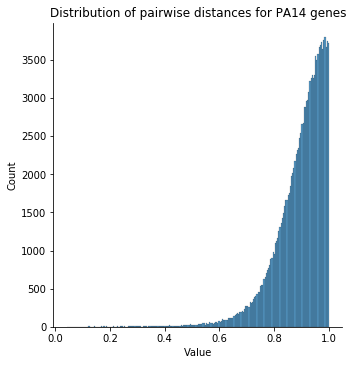

In [32]:
f4 = sns.displot(pa14_local_dist["Value"])
plt.title("Distribution of pairwise distances for PA14 genes")

In [33]:
# Save log transform + SPELL correlation matrices
pao1_log_spell_mat_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pao1_{subset_genes}_log_spell_mat.tsv"
)
pa14_log_spell_mat_filename = os.path.join(
    paths.LOCAL_DATA_DIR, f"pa14_{subset_genes}_log_spell_mat.tsv"
)
pao1_corr_log_spell.to_csv(pao1_log_spell_mat_filename, sep="\t")
pa14_corr_log_spell.to_csv(pa14_log_spell_mat_filename, sep="\t")